In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


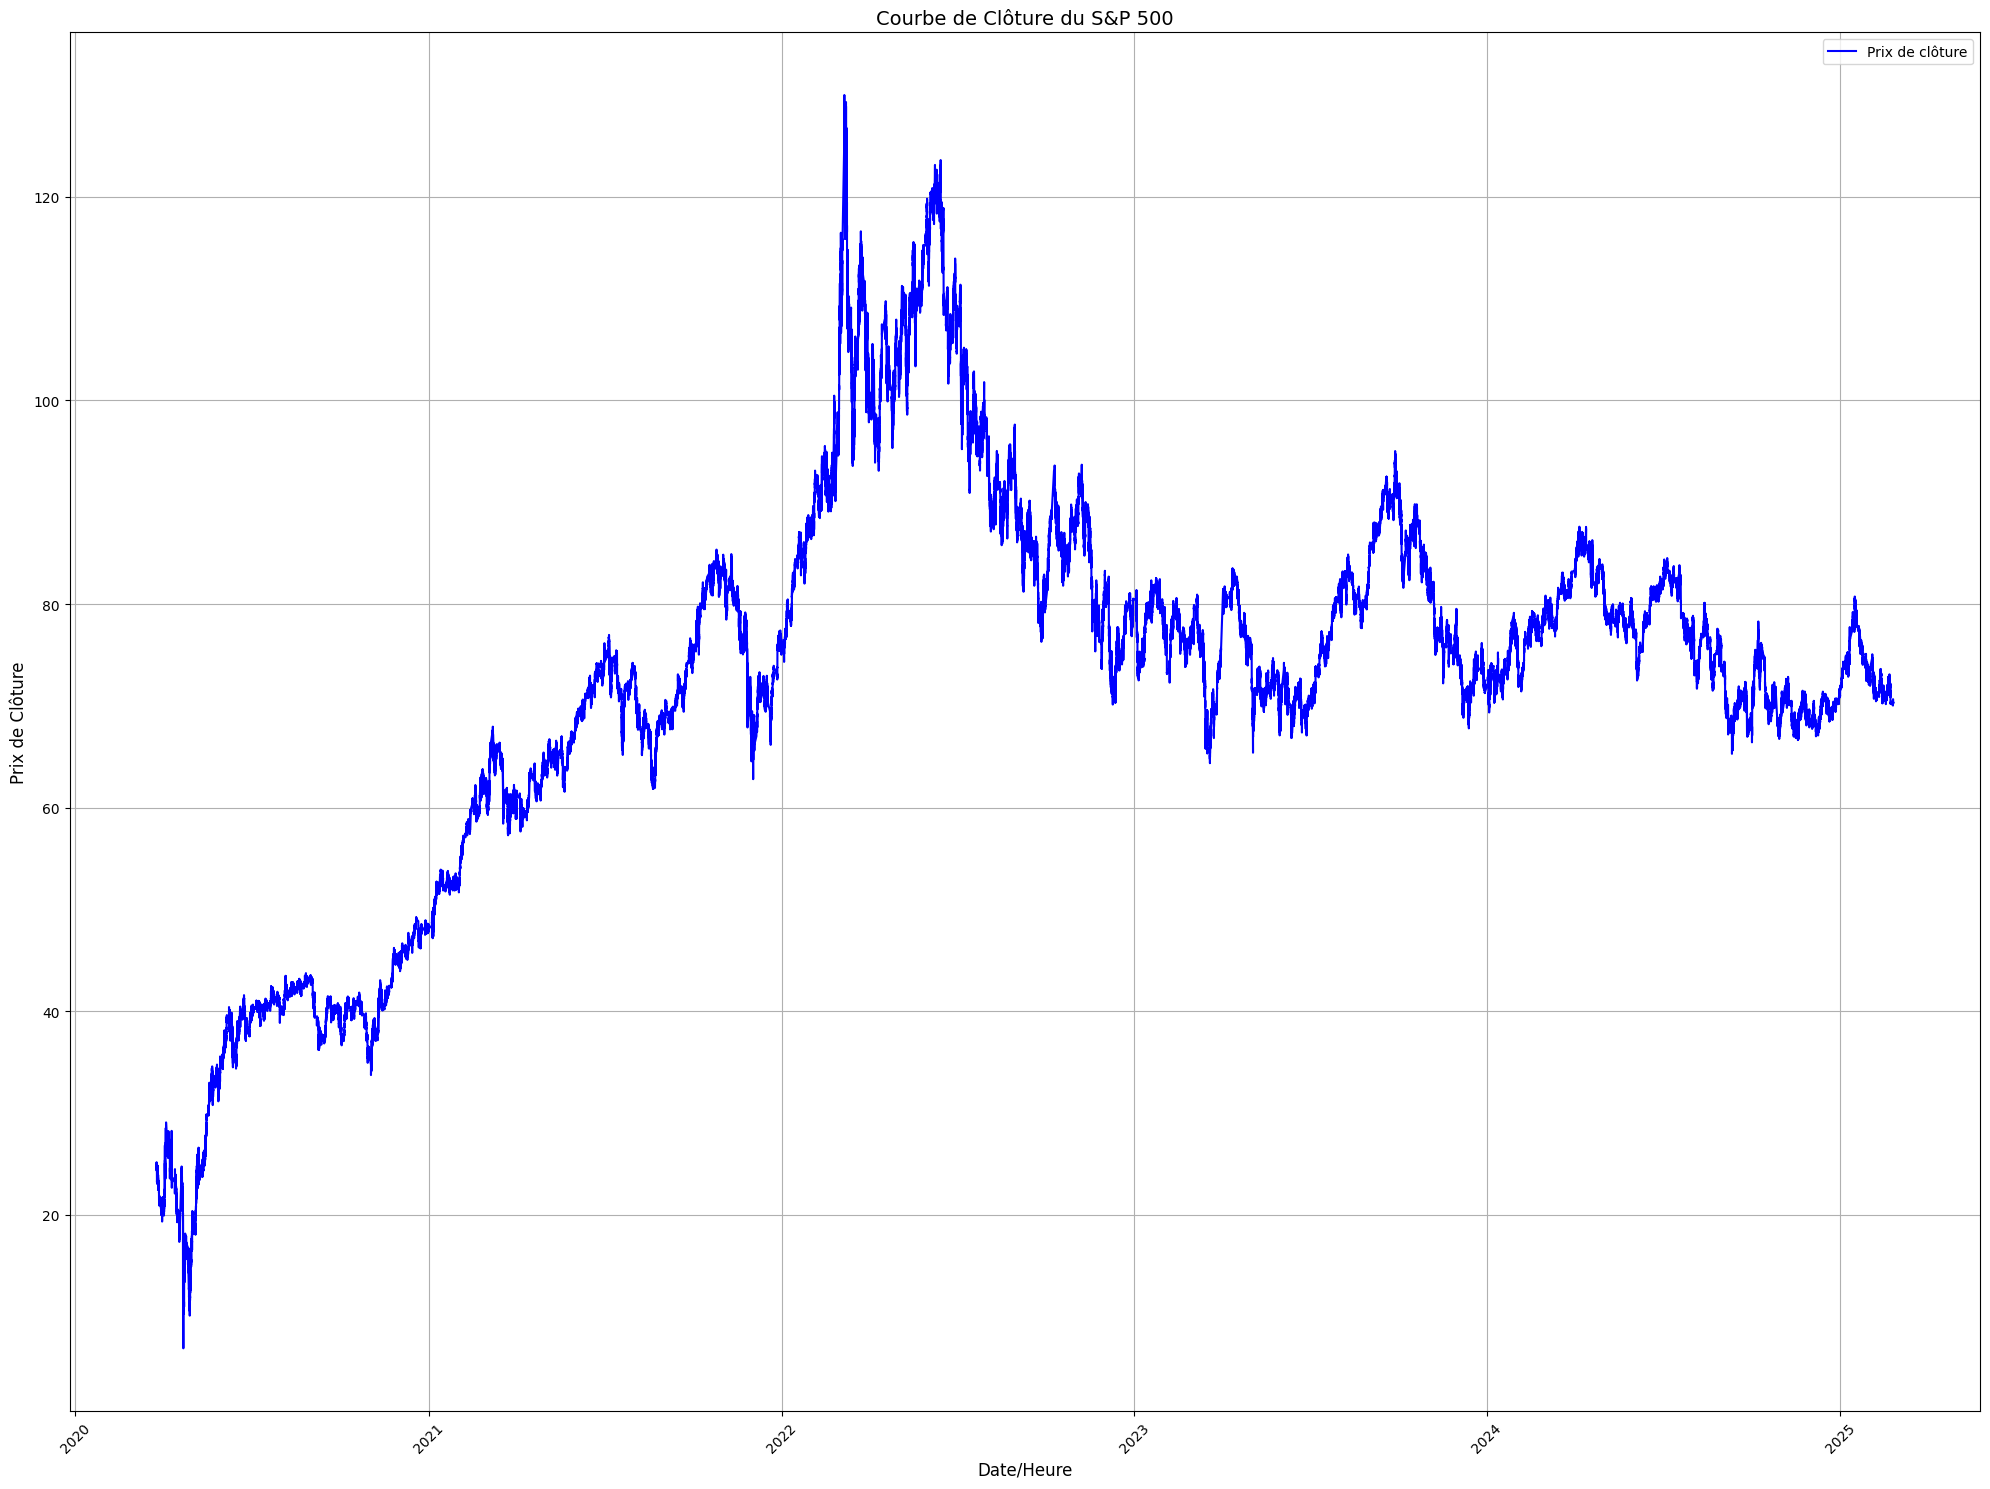

In [1]:
from processing_functions import create_df_M5
import matplotlib.pyplot as plt 

df_M5 = create_df_M5(use3UT=False) #chopPeriod=14)

plt.figure(figsize=(20,15))
plt.plot(df_M5['datetime'], df_M5['close'], label='Prix de clôture', color='b')
plt.title('Courbe de Clôture du S&P 500', fontsize=14)
plt.xlabel('Date/Heure', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

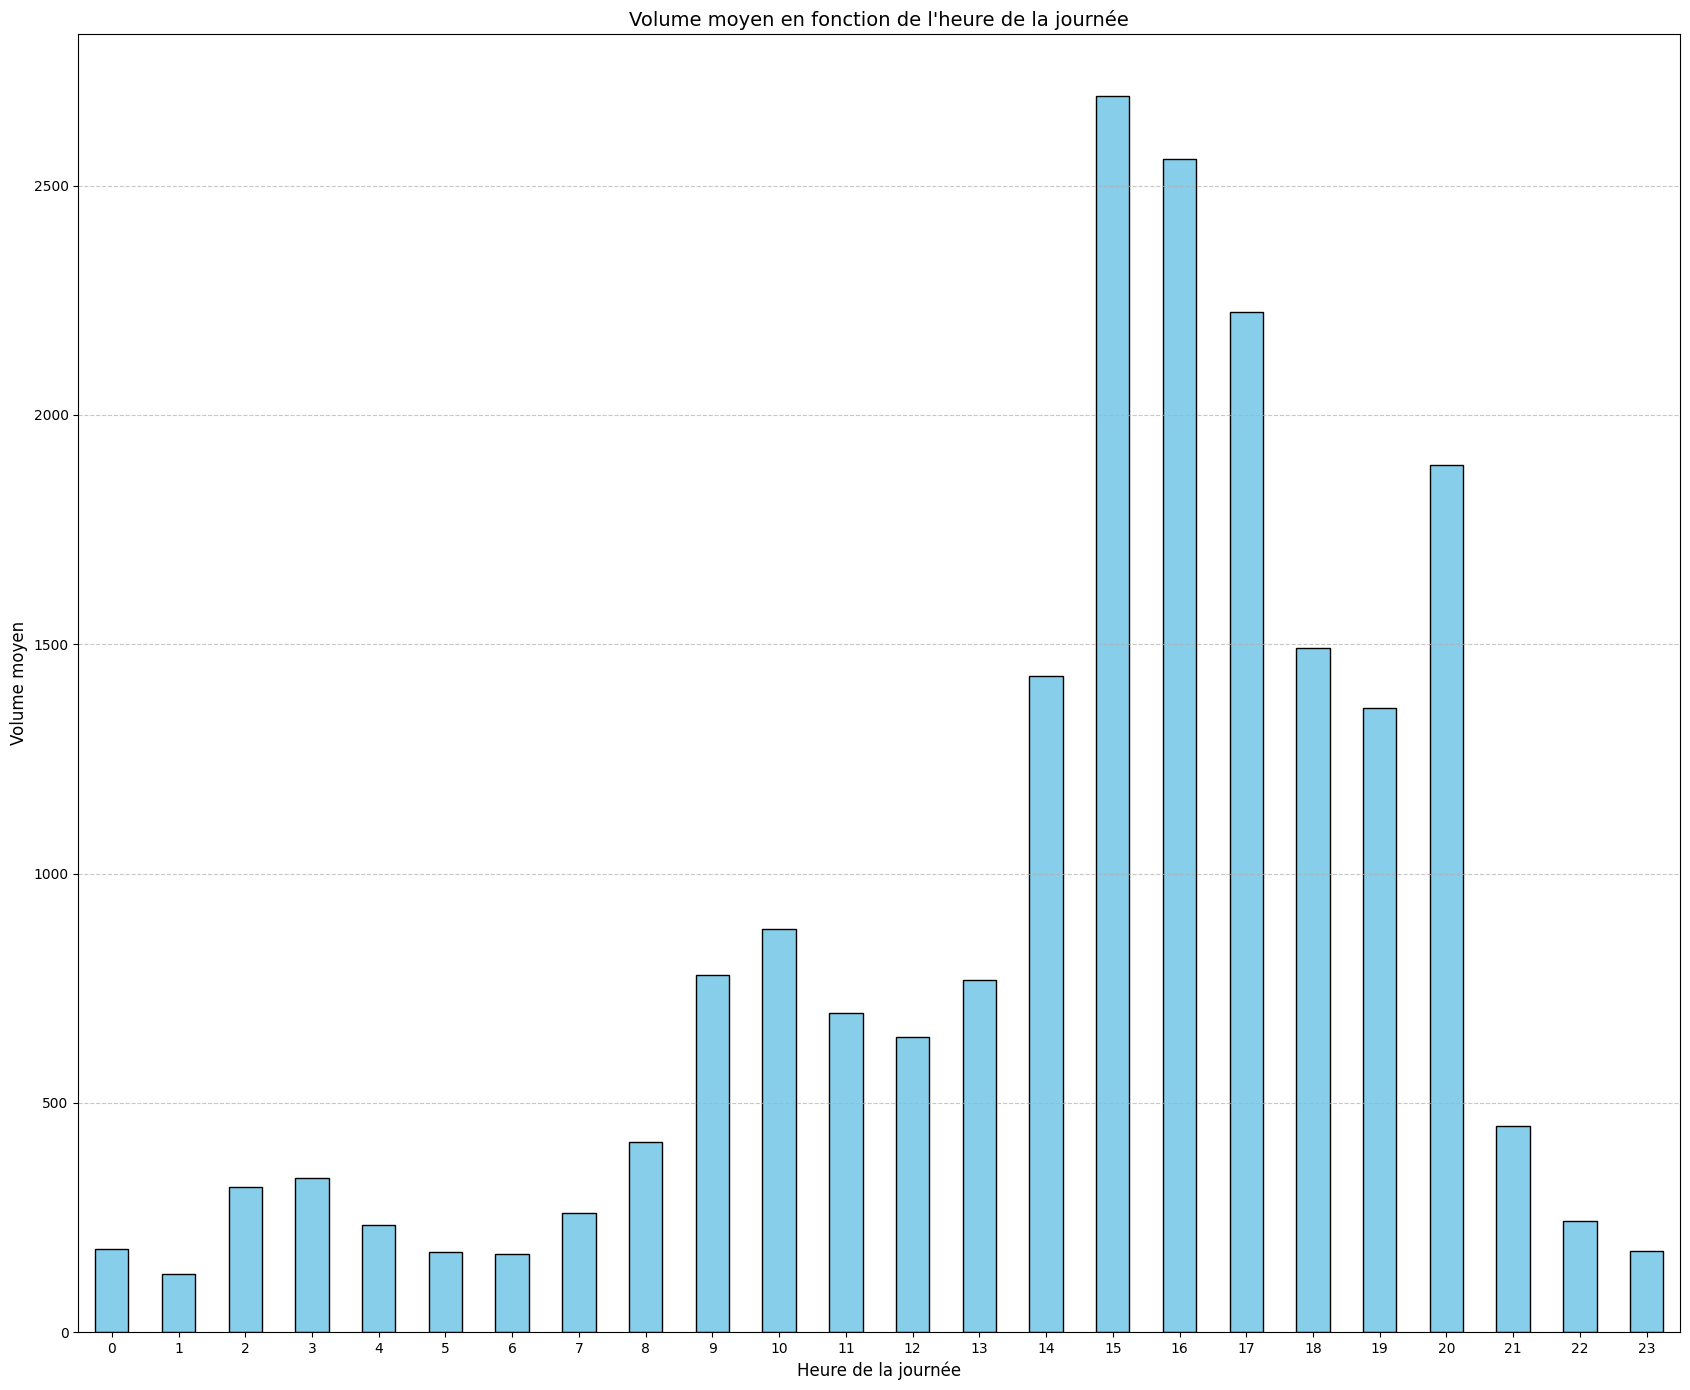

In [ ]:

# Extraire l'heure de la journée à partir de 'timestamp'
df_M5['hour'] = df_M5['datetime'].dt.hour

# Calculer le volume moyen pour chaque heure
volume_moyen_par_heure = df_M5.groupby('hour')['volume'].mean()

# Affichage des résultats sous forme d'histogramme
plt.figure(figsize=(17, 14))
volume_moyen_par_heure.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Volume moyen en fonction de l\'heure de la journée', fontsize=14)
plt.xlabel('Heure de la journée', fontsize=12)
plt.ylabel('Volume moyen', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

In [ ]:
##### DEPRECATED : WE NOW USE THE MULTIPROCESSING SCRIPT, IT's FASTER #####
import strategy_runner
from strategies.DTP_Strategy import DTP
from datetime import datetime
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

trades_database = {}

params = {
    "stopMethods": [2], # [1, 2],
    "slInTicks": [25,50,75,100],
    "tpInTicks": [25,50,75,100],
    "onlyUSSession": [True, False]
}
use3UT = False
useAllEntryPoints = False

strategy = DTP(df_M5[:350_000], use3UT, useAllEntryPoints)
iteration = 1
for sm in params["stopMethods"]:
    for sl in params["slInTicks"]:
        for tp in params["tpInTicks"]:
            for onlyUSSession in params["onlyUSSession"]:
                if tp/sl < 1.6: # On ne veut que des trade avec un risk ratio >= à 1
                    start_time = datetime.now()
                    print(f'parameters: sl={sl}, tp={tp}, US_hours_only={onlyUSSession}, sm={sm} are being tested...')
                    trades = strategy_runner.strategyLoop(strategy, sl, tp, onlyUSSession, stopMethod=sm)
                    trades_database[iteration] = [trades, sl, tp, onlyUSSession, sm]
                    end_time = datetime.now()
                    print(f'iteration n°{iteration} finished in {end_time-start_time}')
                    iteration+=1


parameters: sl=25, tp=25, US_hours_only=True, sm=2 are being tested...
iteration n°1 finished in 0:01:29.705482
parameters: sl=25, tp=25, US_hours_only=False, sm=2 are being tested...
iteration n°2 finished in 0:02:55.396519
parameters: sl=50, tp=25, US_hours_only=True, sm=2 are being tested...
iteration n°3 finished in 0:01:26.159525
parameters: sl=50, tp=25, US_hours_only=False, sm=2 are being tested...
iteration n°4 finished in 0:02:54.232397
parameters: sl=50, tp=50, US_hours_only=True, sm=2 are being tested...
iteration n°5 finished in 0:01:26.785282
parameters: sl=50, tp=50, US_hours_only=False, sm=2 are being tested...
iteration n°6 finished in 0:02:50.052571
parameters: sl=50, tp=75, US_hours_only=True, sm=2 are being tested...
iteration n°7 finished in 0:01:25.708805
parameters: sl=50, tp=75, US_hours_only=False, sm=2 are being tested...
iteration n°8 finished in 0:03:01.773370
parameters: sl=75, tp=25, US_hours_only=True, sm=2 are being tested...
iteration n°9 finished in 0:0

In [1]:
from processing_functions import load_object, create_winrate_dictionnary, plot_backtested_return_curve

In [ ]:
import pandas as pd
print('basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_nokijunTest')
trades_database = load_object('trade_datas/MES/basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_nokijunTest.pkl')
winrate_dictionnary = create_winrate_dictionnary(trades_database, 2)
pd.DataFrame.from_dict(winrate_dictionnary, orient='index')

basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_nokijunTest


,Winrate [%],Total return [%],Avg. gain [%],Avg. loss [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,mta,use3UT
1,47.311,240.81,0.24,-0.08,0.82,"(1601, 1783, 12)",24.4,20,0 days 00:30:00,0 days 00:55:00,2,False,2,False
4,35.369,244.45,0.49,-0.10,1.87,"(776, 1418, 14)",26.8,50,0 days 00:45:00,0 days 01:25:00,2,False,2,False
2,44.053,259.39,0.29,-0.09,1.02,"(1389, 1764, 16)",24.5,25,0 days 00:30:00,0 days 01:00:00,2,False,2,False
3,39.597,265.24,0.38,-0.09,1.37,"(1081, 1649, 16)",25.6,35,0 days 00:35:00,0 days 01:10:00,2,False,2,False


In [ ]:
import pandas as pd
print('basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_2TP_1M')
trades_database = load_object('trade_datas/MES/basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_2TP_1M.pkl')
winrate_dictionnary = create_winrate_dictionnary(trades_database, 2)
pd.DataFrame.from_dict(winrate_dictionnary, orient='index')

basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_2TP_1M


,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,use3UT
7,31.800,477.93,451.94,0.25,-0.04,4.66,"(2862, 6138, 154)",12.3,"(35, 45)",0 days 00:11:00,0 days 00:23:00,2,False,False
6,32.058,492.75,465.78,0.25,-0.04,4.25,"(2992, 6341, 165)",12.4,"(35, 35)",0 days 00:11:00,0 days 00:23:00,2,False,False
9,32.326,509.68,481.87,0.24,-0.04,4.11,"(3114, 6519, 159)",12.2,"(30, 40)",0 days 00:11:00,0 days 00:22:00,2,False,False
4,32.820,520.04,491.17,0.24,-0.04,3.70,"(3283, 6720, 164)",12.2,"(30, 30)",0 days 00:10:00,0 days 00:21:00,2,False,False
8,33.161,535.17,506.06,0.24,-0.04,3.73,"(3343, 6738, 169)",12.1,"(25, 40)",0 days 00:10:00,0 days 00:21:00,2,False,False
5,33.320,542.34,512.76,0.23,-0.04,3.53,"(3412, 6828, 174)",12.1,"(25, 35)",0 days 00:10:00,0 days 00:21:00,2,False,False
10,34.399,551.44,520.85,0.22,-0.04,3.38,"(3648, 6957, 168)",11.8,"(20, 40)",0 days 00:10:00,0 days 00:20:00,2,False,False
3,34.139,552.74,521.95,0.22,-0.04,3.12,"(3642, 7026, 175)",12.0,"(25, 25)",0 days 00:10:00,0 days 00:20:00,2,False,False
1,36.014,559.17,526.27,0.20,-0.04,2.54,"(4111, 7304, 170)",11.8,"(20, 20)",0 days 00:09:00,0 days 00:17:00,2,False,False
2,34.785,563.17,531.50,0.22,-0.04,2.96,"(3818, 7158, 173)",11.8,"(20, 30)",0 days 00:09:00,0 days 00:19:00,2,False,False


In [ ]:
pathOfData = 'trade_datas/MES/basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_2TP_1M.pkl'
trades_database = load_object(pathOfData)
selected_Id = 2
df_temp =  trades_database[selected_Id][0]

# Définir 'datetime' comme index pour pouvoir utiliser resample
df_temp.set_index('entry_date', inplace=True)

# Resampler les données par semaine (par exemple, la somme des profits par semaine)
df_weekly = df_temp.resample('W').agg({'profit_including_fees_from_start(%)': ['sum']})
df_daily = df_temp.resample('D').agg({'profit_including_fees_from_start(%)': ['sum']})
del df_temp

print(df_daily.describe(),'\n', df_weekly.describe())


      profit_including_fees_from_start(%)
                                      sum
count                         1798.000000
mean                             0.295608
std                              0.466618
min                             -1.400845
25%                              0.000000
50%                              0.106682
75%                              0.523799
max                              3.042060 
       profit_including_fees_from_start(%)
                                      sum
count                          258.000000
mean                             2.060087
std                              1.487199
min                             -0.604235
25%                              0.940510
50%                              1.831997
75%                              2.782430
max                              7.935585


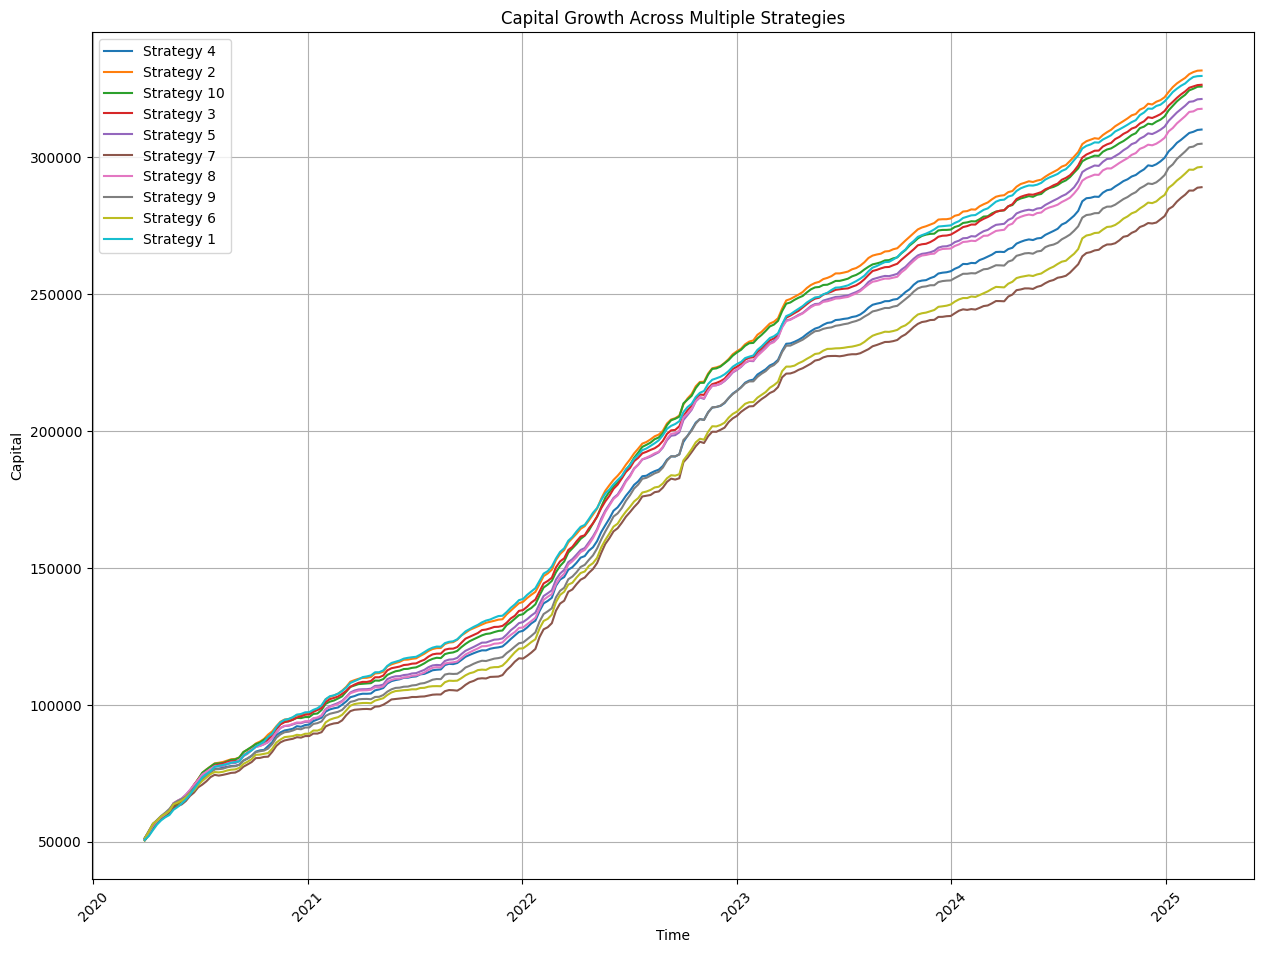

In [ ]:
plot_backtested_return_curve(pathOfData='trade_datas/MES/basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_2TP_1M.pkl',
                             plotAllDatas=True,
                             plotSize=(15,11))

In [ ]:
import pandas as pd
print('basicEntries_pivot_StrategyStop2_tenkanAngle_5contracts_2TP_1M')
trades_database = load_object('trade_datas/CL/basicEntries_pivot_StrategyStop2_1contracts_2TP_1M.pkl')
winrate_dictionnary = create_winrate_dictionnary(trades_database, 2)
pd.DataFrame.from_dict(winrate_dictionnary, orient='index')

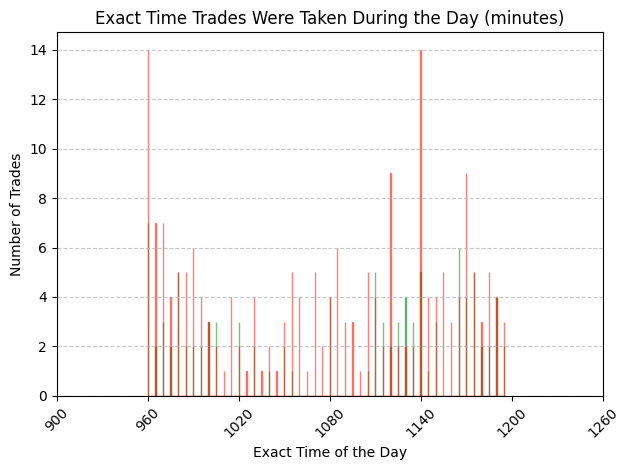

In [14]:
import matplotlib.pyplot as plt

id = 7
df, _, _, _ = trades_database[id]

df_hist_w = df[df['profit_from_start(%)']>0]['entry_date'].apply(lambda x: x.hour*60 + x.minute)
df_hist_l = df[df['profit_from_start(%)']<0]['entry_date'].apply(lambda x: x.hour*60 + x.minute)

# Plot the histogram
plt.hist(df_hist_w, bins=1440, edgecolor='green', alpha=0.5)
plt.hist(df_hist_l, bins=1440, edgecolor='red', alpha=0.5)

plt.xlabel('Exact Time of the Day')
plt.ylabel('Number of Trades')
plt.title('Exact Time Trades Were Taken During the Day (minutes)')
plt.xticks(range(900, 1320, 60), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensures labels fit inside the plot
plt.show()

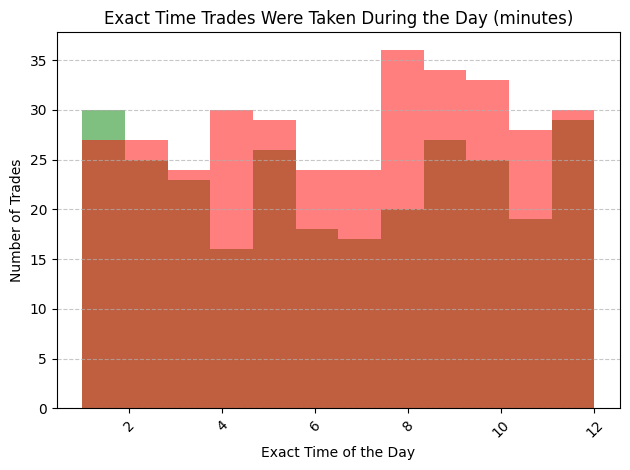

In [5]:
import matplotlib.pyplot as plt

id = 18
df, _, _, _ = trades_database[id]

df_hist_w = df[df['profit_from_start(%)']>0]['entry_date'].dt.month
df_hist_l = df[df['profit_from_start(%)']<0]['entry_date'].dt.month
months = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']
# Plot the histogram
plt.hist(df_hist_w, bins=12, color='green', alpha=0.5)
plt.hist(df_hist_l, bins=12, color='red', alpha=0.5)

plt.xlabel('Exact Time of the Day')
plt.ylabel('Number of Trades')
plt.title('Exact Time Trades Were Taken During the Day (minutes)')
plt.xticks(rotation=45, )#ticks=range(1, 13), labels=months)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensures labels fit inside the plot
plt.show()

choses à faire pour continuer à backtest :
- avoir le temps moyen d'un trade avec la stratégie DTP : FAIT!
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $ : FAIT!
- stop loss suiveur : passe en breakeven sous certaines conditions 